# 1D Cantera (Burke mechanism)

This notebook runs a 1D freely propagating flame using the Burke mechanism (YAML file in `flamekit/chemical_mech/BurkeH2.yaml`).
It computes, for each species, the term `cp_k * Y_k * V_k` and the enthalpy source term `h_k * omega_k`, and plots each term vs temperature.


In [1]:
from __future__ import annotations
from pathlib import Path
import math

import cantera as ct
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Configuration
# -----------------------------
mech_path = Path("flamekit/chemical_mech/BurkeH2.yaml")
if not mech_path.exists():
    raise FileNotFoundError(f"Mechanism file not found: {mech_path.resolve()}")

pressure = ct.one_atm
T0 = 300.0
phi = 0.40
fuel = "H2:1"
oxidizer = "O2:1, N2:3.76"
width = 0.03  # m

gas = ct.Solution(mech_path.as_posix())
gas.TP = T0, pressure
gas.set_equivalence_ratio(phi, fuel, oxidizer)


In [2]:
# -----------------------------
# Solve 1D free flame
# -----------------------------
flame = ct.FreeFlame(gas, width=width)
flame.transport_model = "Mix"
flame.set_refine_criteria(ratio=3.0, slope=0.06, curve=0.12)
flame.solve(loglevel=1, auto=True)

print(f"Solved flame with {flame.grid.size} grid points")
print(f"T range: {flame.T.min():.1f} K to {flame.T.max():.1f} K")


/home/alexandros/venvs/myproject/lib/python3.12/site-packages/cantera/onedim.py:194: DeprecationWarning: FactoryBase::canonicalize: Model name 'Mix' is deprecated. Use 'mixture-averaged' instead.
  self.flame.transport_model = model



************ Solving on 8 point grid with energy equation enabled ************

..............................................................................

Attempt Newton solution of steady-state problem.
Newton steady-state solve failed.

Attempt 10 timesteps.
Final timestep info: dt= 0.0001709  log(ss)= 4.466     

Attempt Newton solution of steady-state problem.
Newton steady-state solve failed.

Attempt 10 timesteps.
Final timestep info: dt= 0.004379   log(ss)= 3.897     

Attempt Newton solution of steady-state problem.
Newton steady-state solve failed.

Attempt 10 timesteps.
Final timestep info: dt= 0.1122     log(ss)= 2.741     

Attempt Newton solution of steady-state problem.
Newton steady-state solve succeeded.

Problem solved on [9] point grid(s).
Expanding domain to accommodate flame thickness. New width: 0.06 m
##############################################################################
Refining grid in flame.
    New points inserted after grid points 0 1 2 3 4 5 6 

In [3]:
# -----------------------------
# cp_k * Y_k * V_k (per species) and h_k * omega_k
# -----------------------------
x = flame.grid
T = flame.T
Y = flame.Y  # (n_species, n_points)
rho = flame.density  # (n_points,)
D = flame.mix_diff_coeffs  # (n_species, n_points)

# Mixture-averaged diffusion velocity via diffusive flux (zero-net-flux correction)
dYdx = np.gradient(Y, x, axis=1)
j = -rho[None, :] * D * dYdx  # (n_species, n_points)
j[-1, :] = -np.sum(j[:-1, :], axis=0)

rhoY = rho[None, :] * Y
V = np.zeros_like(j)
mask = rhoY > 0
V[mask] = j[mask] / rhoY[mask]

# Species cp (mass basis)
try:
    cp_k_molar = flame.partial_molar_cp  # (n_species, n_points) [J/kmol/K]
except AttributeError:
    cp_k_molar = np.empty_like(j)
    for i in range(T.size):
        gas.TPY = T[i], pressure, Y[:, i]
        cp_k_molar[:, i] = gas.partial_molar_cp

cp_k = cp_k_molar / gas.molecular_weights[:, None]  # (n_species, n_points) [J/kg/K]
cpYV = cp_k * Y * V  # (n_species, n_points)

h = flame.partial_molar_enthalpies  # (n_species, n_points) [J/kmol]
omega = flame.net_production_rates  # (n_species, n_points) [kmol/m^3/s]
hk_omega = h * omega  # (n_species, n_points) [W/m^3]

species = gas.species_names
order = np.argsort(T)
T_sorted = T[order]
rho_sorted = rho[order]
dTdx = np.gradient(T, x)
gradT_abs_sorted = np.abs(dTdx)[order]
cpYV_sorted = cpYV[:, order]
hk_sorted = hk_omega[:, order]


## Equations

Mixture-averaged diffusion velocity via the corrected flux:

$$J_k = -\rho D_k \nabla Y_k, \qquad \sum_k J_k = 0$$

$$V_k = \frac{J_k}{\rho Y_k}$$

Computed term:

$$q_k = c_{p,k} \, Y_k \, V_k$$

Enthalpy source term:

$$\dot{q}_k = h_k \, \dot{\omega}_k$$


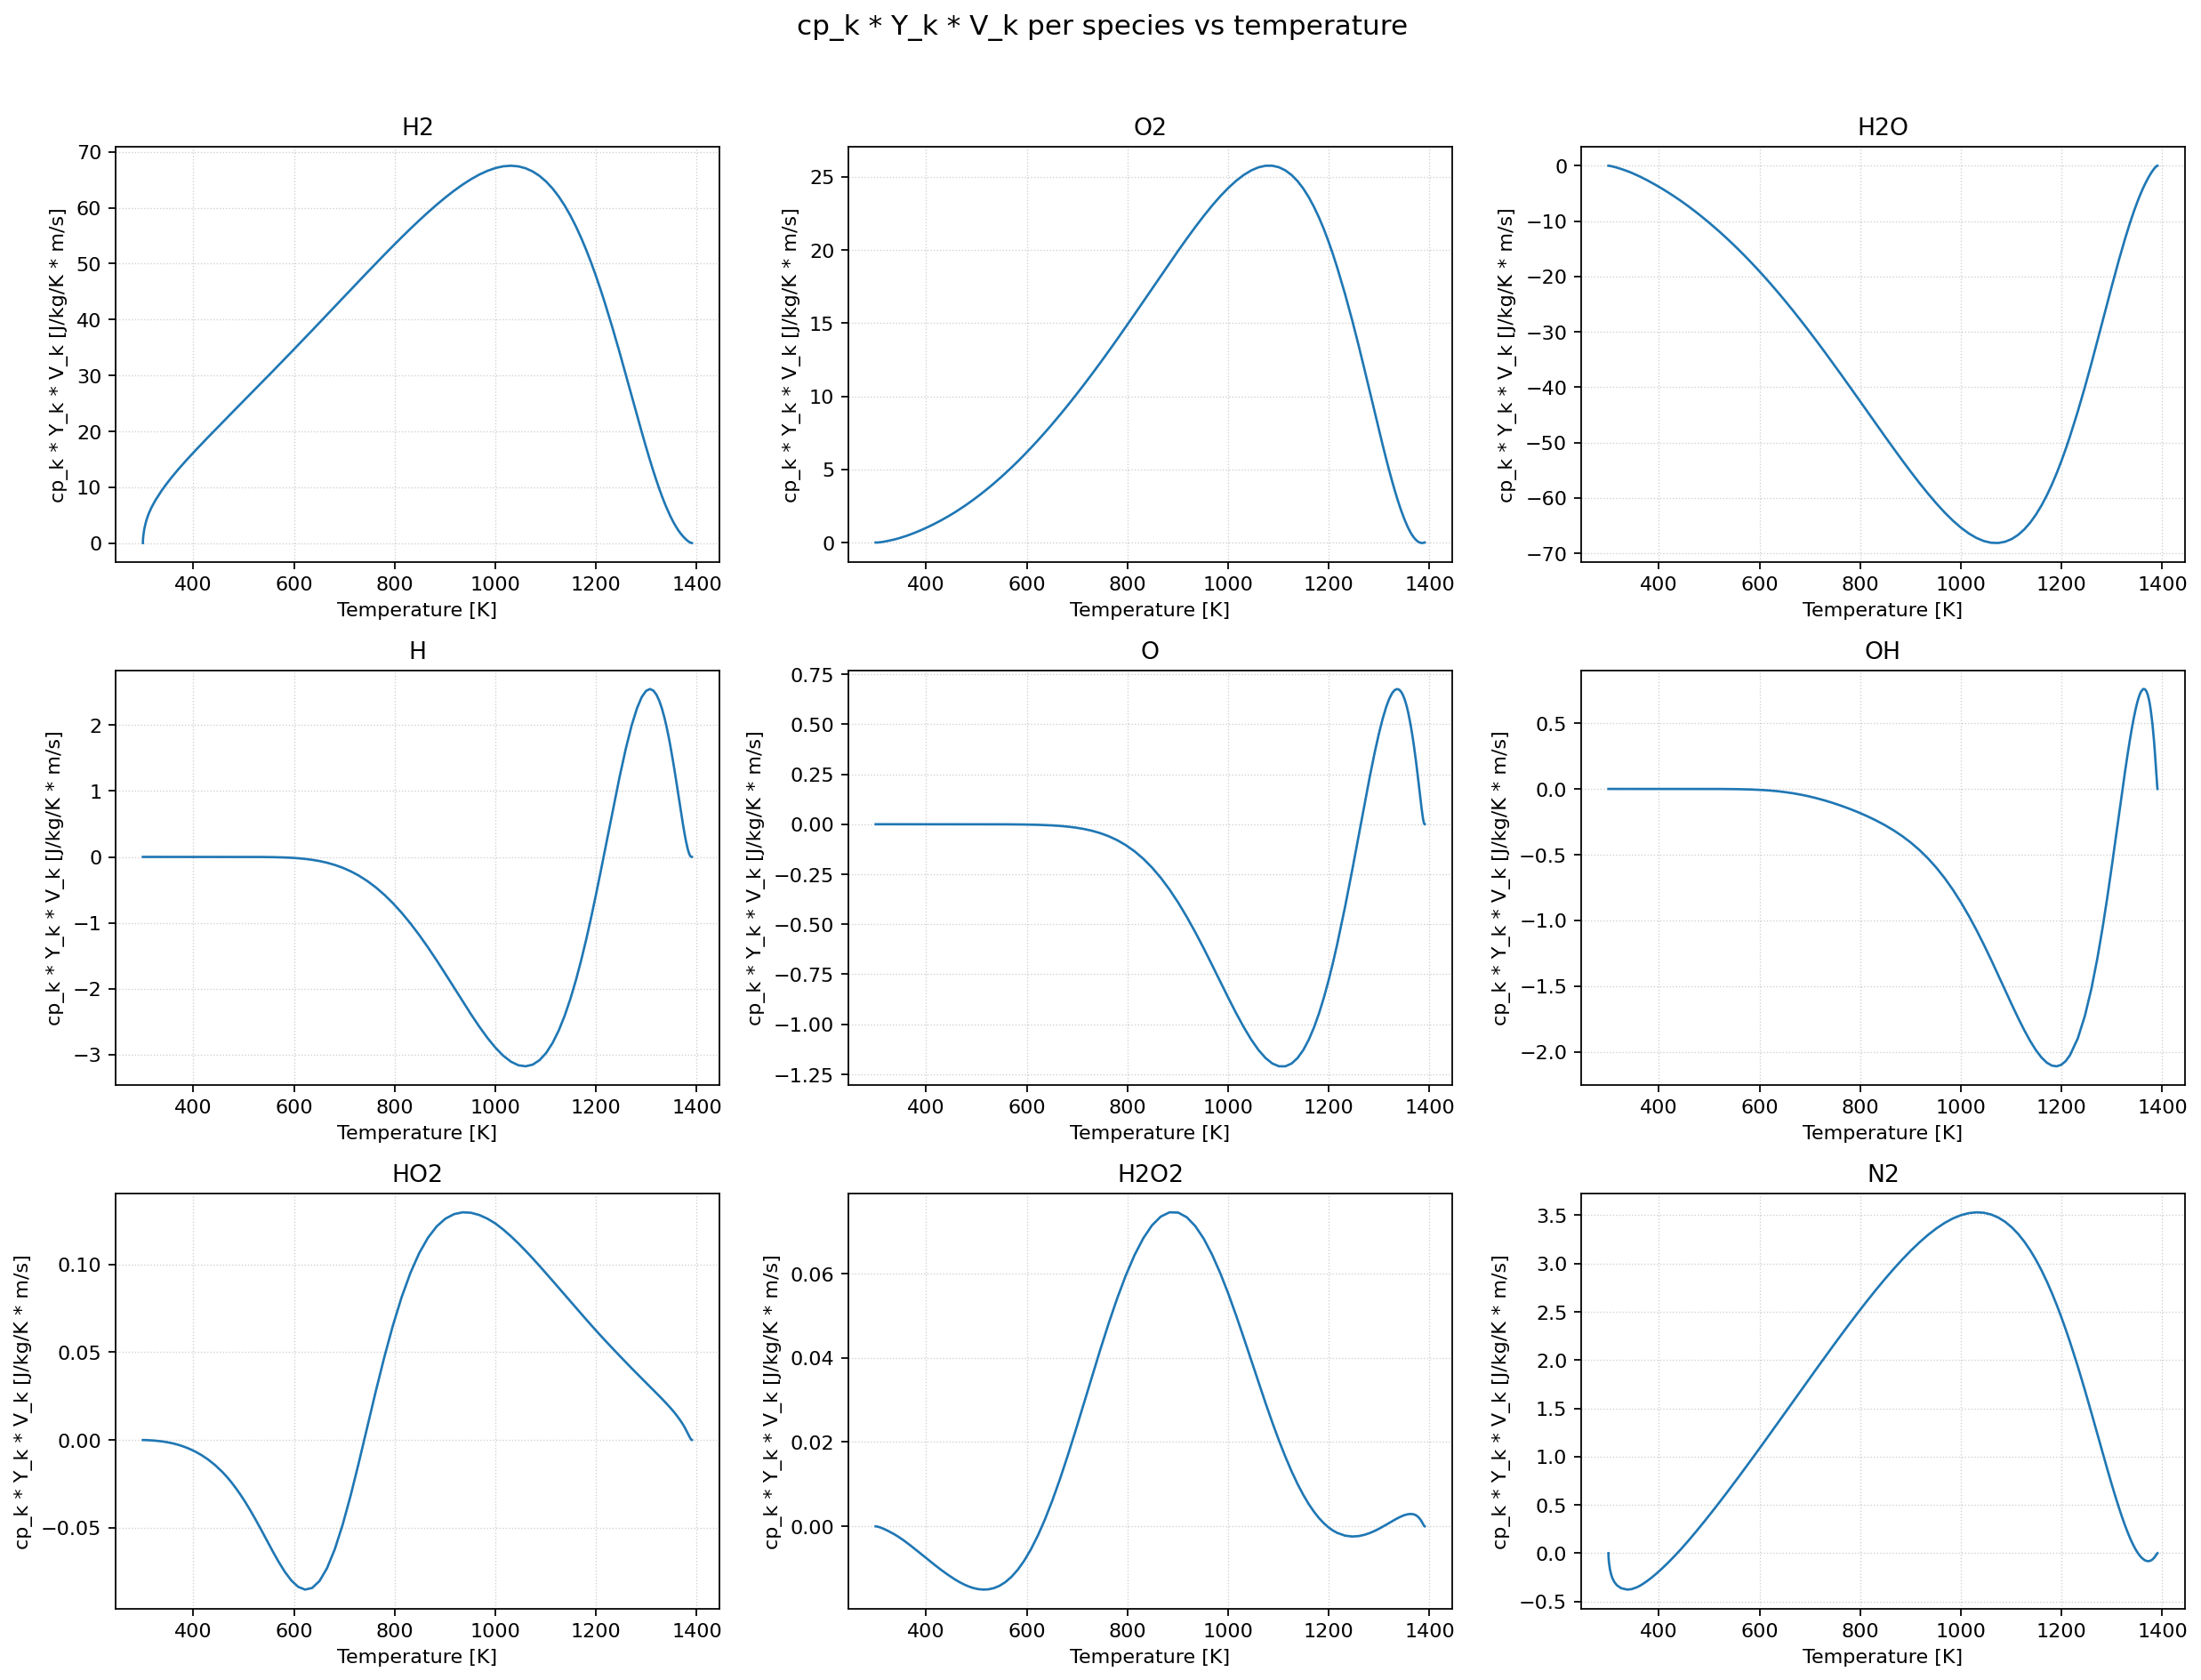

In [4]:
# -----------------------------
# Plot cp_k * Y_k * V_k vs temperature
# -----------------------------
n_species = len(species)
ncols = 3
nrows = math.ceil(n_species / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(5.2 * ncols, 4.0 * nrows), dpi=160)
axes = np.atleast_1d(axes).ravel()

for ax, k, name in zip(axes, range(n_species), species):
    ax.plot(T_sorted, cpYV_sorted[k, :], linewidth=1.2)
    ax.set_title(name)
    ax.set_xlabel("Temperature [K]")
    ax.set_ylabel("cp_k * Y_k * V_k [J/kg/K * m/s]")
    ax.grid(True, linestyle=":", linewidth=0.6, alpha=0.6)

for ax in axes[n_species:]:
    ax.set_axis_off()

fig.suptitle("cp_k * Y_k * V_k per species vs temperature", fontsize=14)
fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


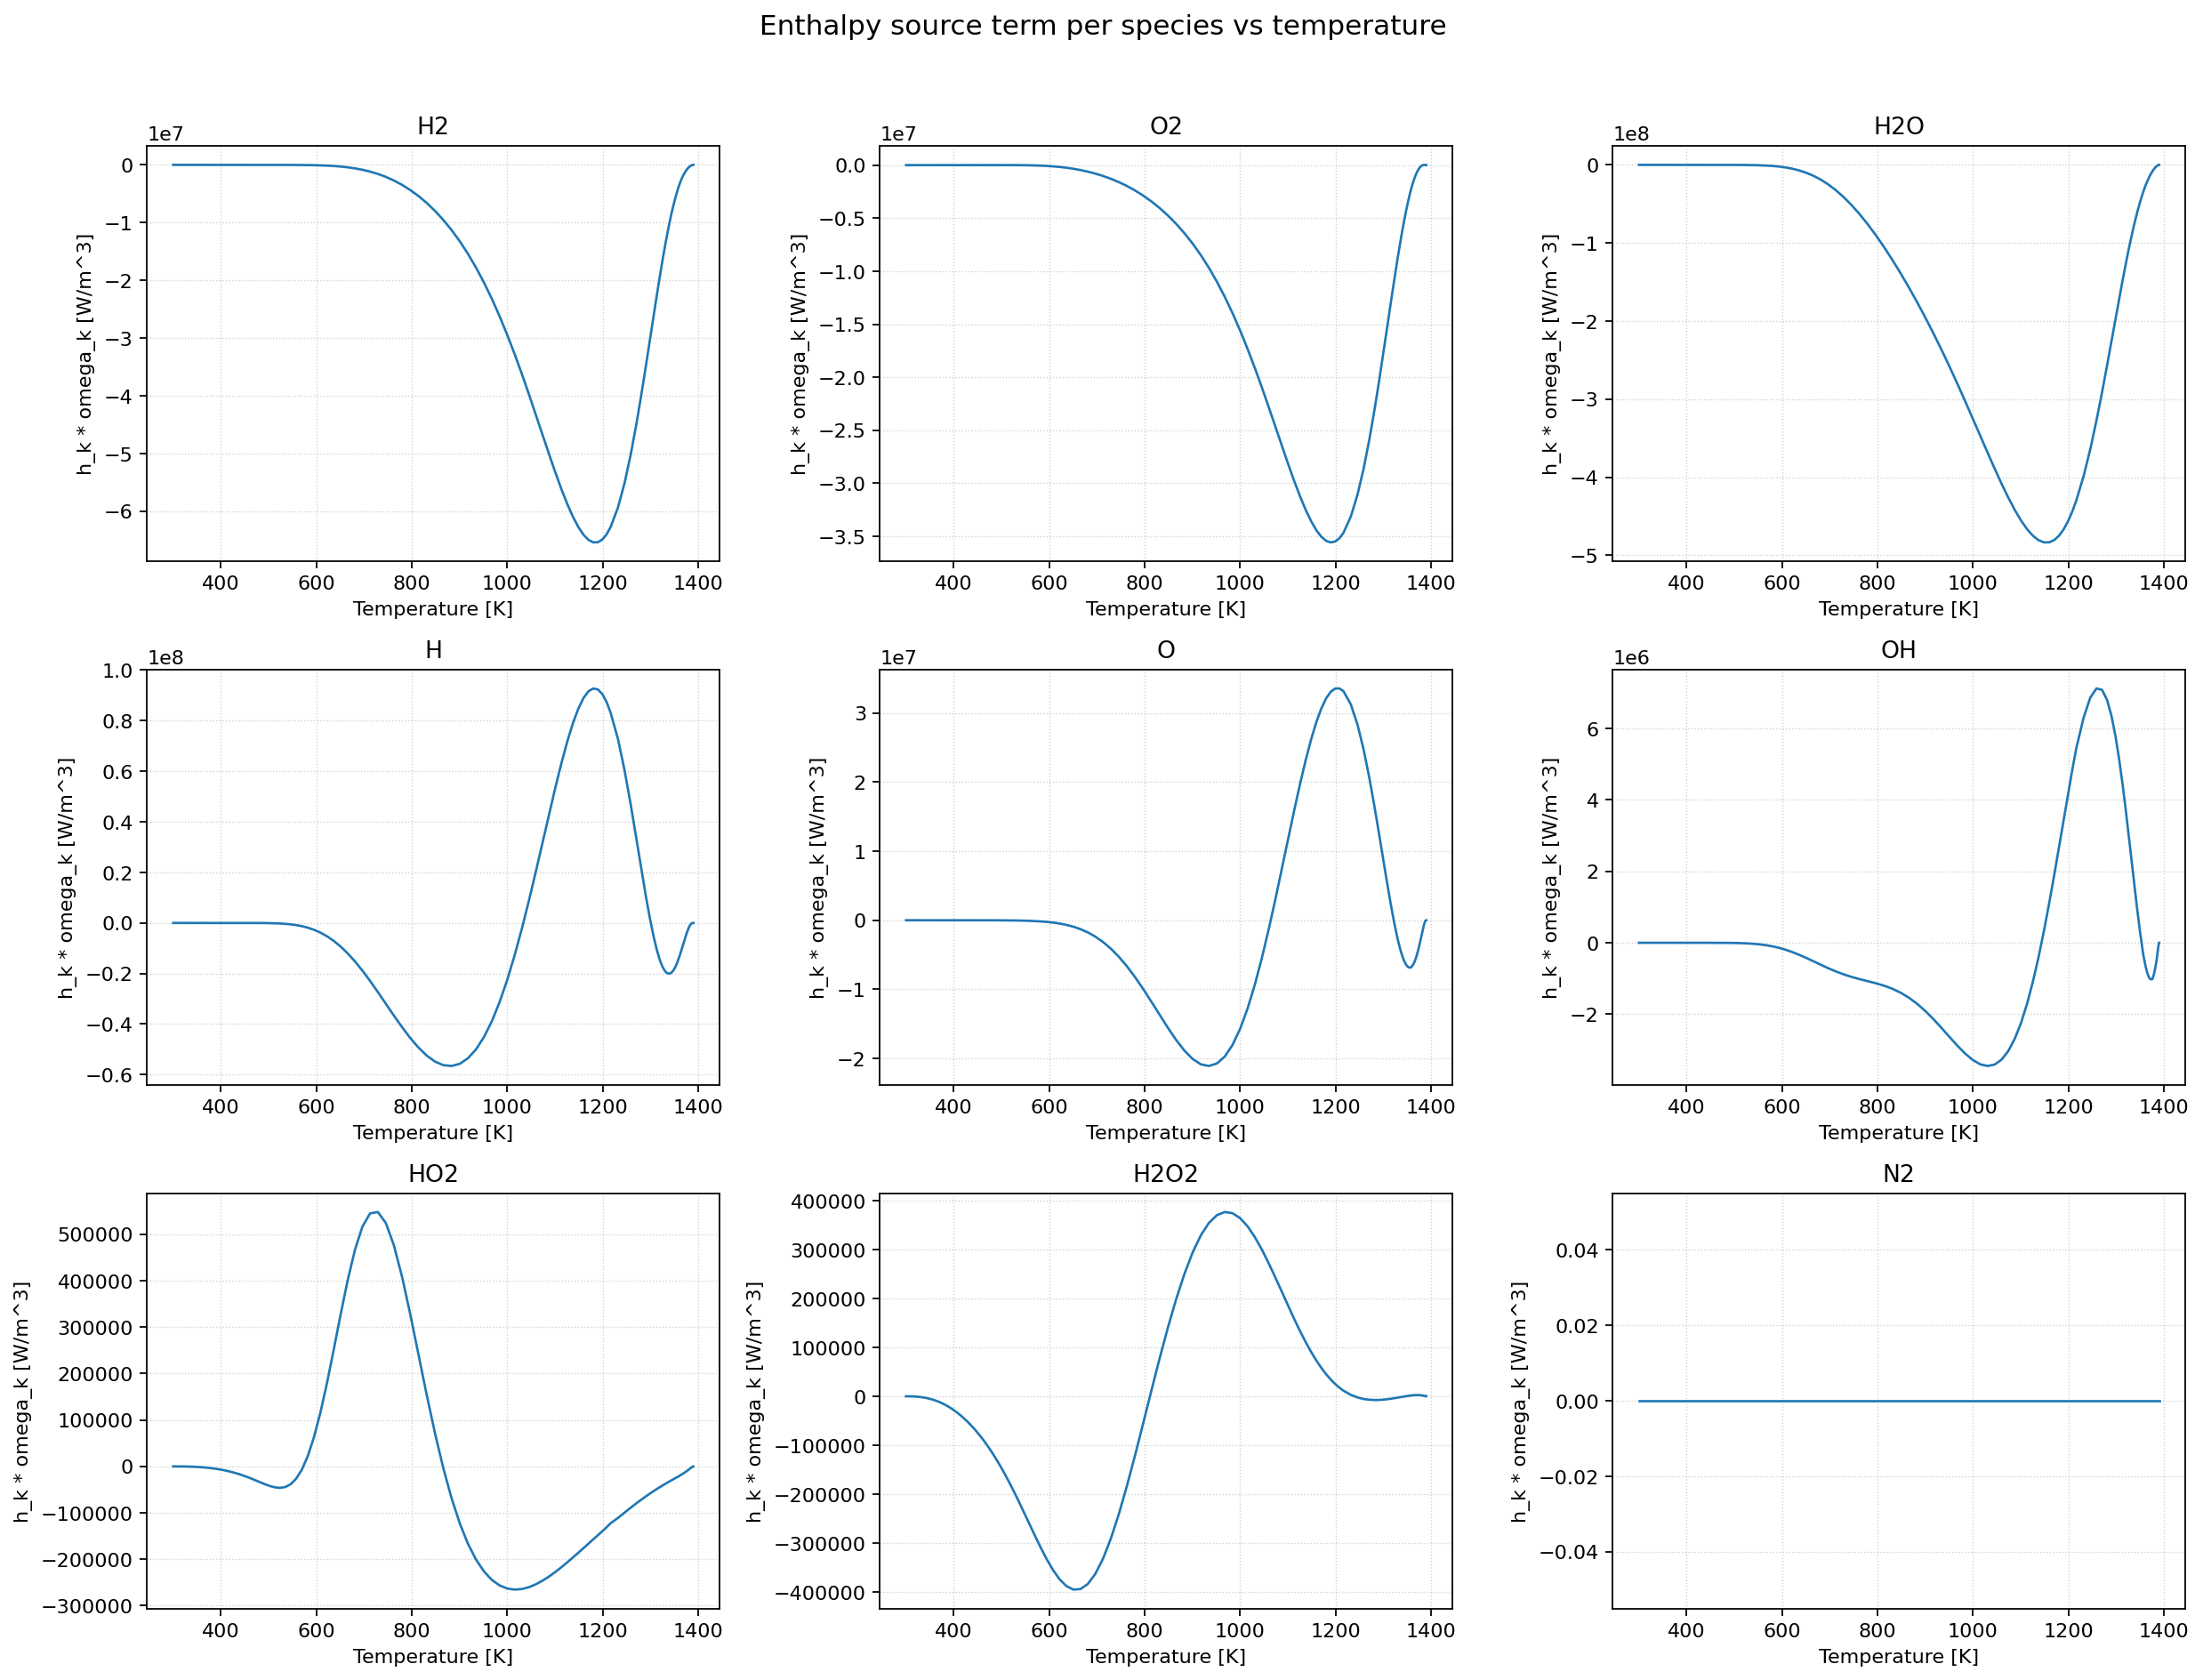

In [5]:
# -----------------------------
# Plot h_k * omega_k vs temperature
# -----------------------------
fig, axes = plt.subplots(nrows, ncols, figsize=(5.2 * ncols, 4.0 * nrows), dpi=160)
axes = np.atleast_1d(axes).ravel()

for ax, k, name in zip(axes, range(n_species), species):
    ax.plot(T_sorted, hk_sorted[k, :], linewidth=1.2)
    ax.set_title(name)
    ax.set_xlabel("Temperature [K]")
    ax.set_ylabel("h_k * omega_k [W/m^3]")
    ax.grid(True, linestyle=":", linewidth=0.6, alpha=0.6)

for ax in axes[n_species:]:
    ax.set_axis_off()

fig.suptitle("Enthalpy source term per species vs temperature", fontsize=14)
fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


Heat-release-rate scaling:

$$\frac{\mathrm{HRR}}{|\nabla T|}$$


/tmp/ipykernel_73646/1180506160.py:16: RuntimeWarning: divide by zero encountered in divide
  ratio = np.where(gradT_abs_sorted > gradT_min, hrr_sorted / gradT_abs_sorted, np.nan)


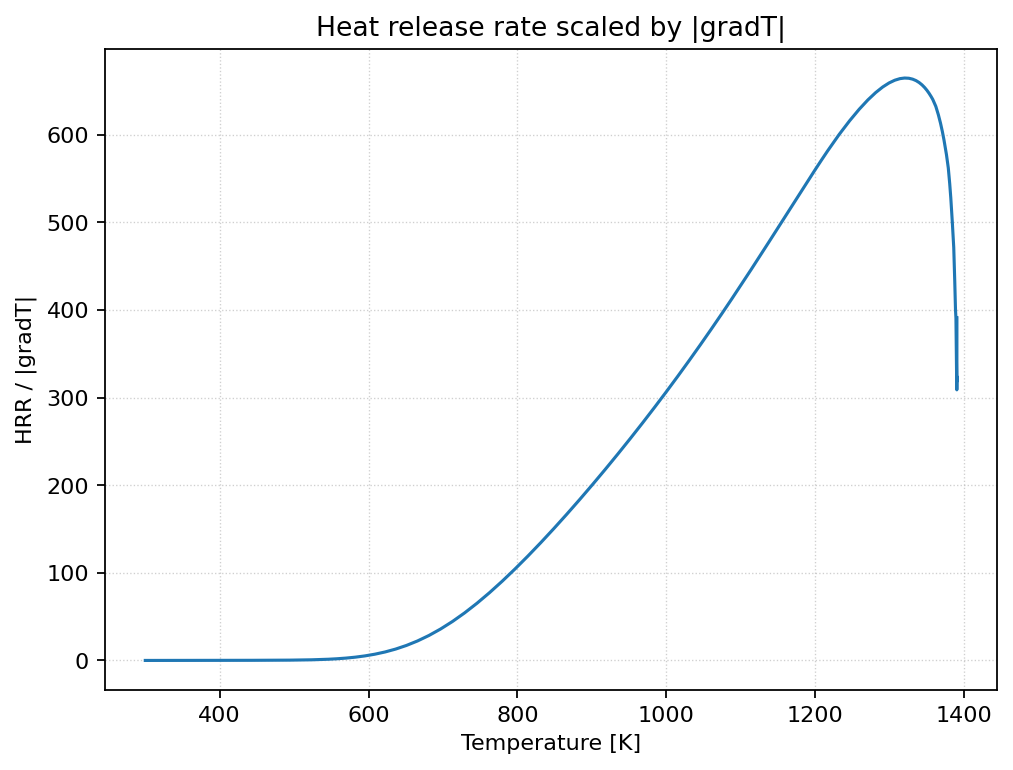

In [6]:
# -----------------------------
# Plot HRR / |gradT| vs temperature
# -----------------------------
try:
    hrr = flame.heat_release_rate
except AttributeError:
    df = flame.to_dataframe()
    if "HRR" not in df.columns:
        raise RuntimeError("HRR not available in flame output. Ensure your mechanism/transport provides it.")
    hrr = df["HRR"].to_numpy()

hrr_sorted = hrr[order]

# Avoid blow-up where |gradT| -> 0
gradT_min = 1e-3  # K/m, adjust if needed
ratio = np.where(gradT_abs_sorted > gradT_min, hrr_sorted / gradT_abs_sorted, np.nan)

fig, ax = plt.subplots(figsize=(7.2, 5.2), dpi=160)
ax.plot(T_sorted, ratio, linewidth=1.4)
ax.set_xlabel("Temperature [K]")
ax.set_ylabel("HRR / |gradT|")
ax.set_title("Heat release rate scaled by |gradT|")
ax.grid(True, linestyle=":", linewidth=0.6, alpha=0.6)
plt.show()


Total weighted sum (multiplied by density):

$$q_{\mathrm{tot}} = \rho \sum_k q_k = \rho \sum_k c_{p,k} \, Y_k \, V_k$$


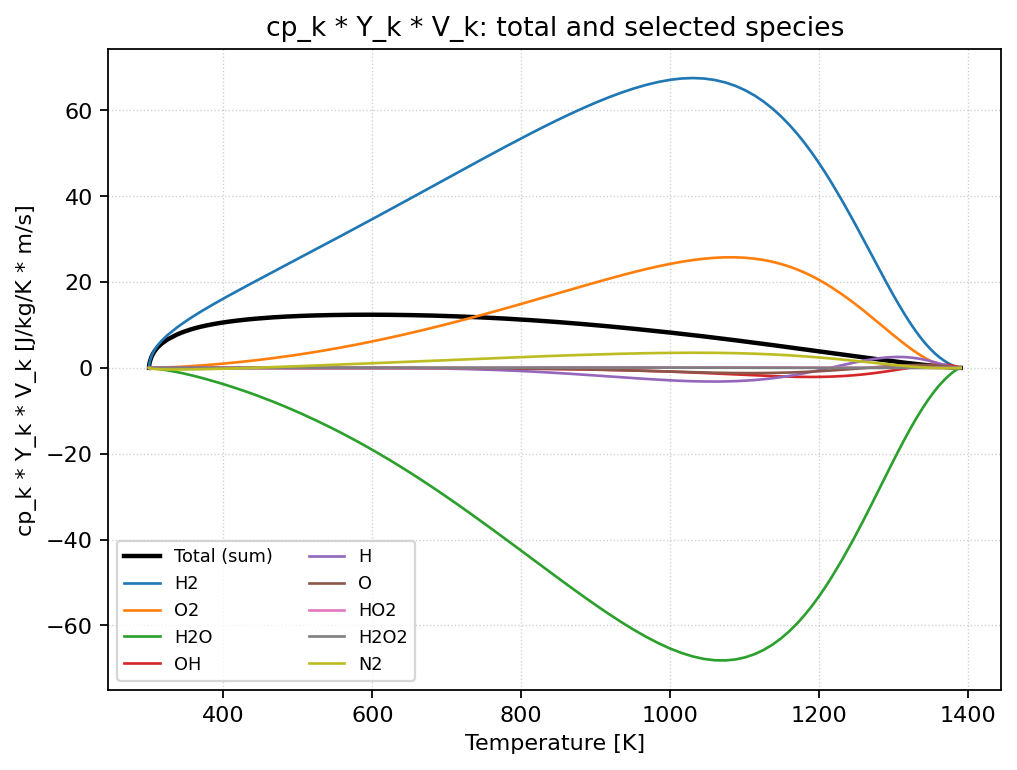

In [7]:
# -----------------------------
# Plot total cp_k * Y_k * V_k + selected species contributions
# -----------------------------
# Edit this list to focus on specific species (empty => total only)
COMPONENTS = ["H2", "O2", "H2O", "OH", "H", "O", "HO2", "H2O2", "N2"]

species_to_idx = {name: i for i, name in enumerate(species)}
plot_species = []
if COMPONENTS:
    missing = [s for s in COMPONENTS if s not in species_to_idx]
    if missing:
        print(f"Warning: components not found: {missing}")
    plot_species = [s for s in COMPONENTS if s in species_to_idx]
    if not plot_species:
        print("No valid components found; plotting total only.")

term_total = np.sum(cpYV_sorted, axis=0) * rho_sorted

fig, ax = plt.subplots(figsize=(7.2, 5.2), dpi=160)
ax.plot(T_sorted, term_total, color="black", linewidth=2.0, label="Total (sum)")

for s in plot_species:
    k = species_to_idx[s]
    ax.plot(T_sorted, cpYV_sorted[k, :], linewidth=1.2, label=s)

ax.set_xlabel("Temperature [K]")
ax.set_ylabel("cp_k * Y_k * V_k [J/kg/K * m/s]")
ax.set_title("cp_k * Y_k * V_k: total and selected species")
ax.grid(True, linestyle=":", linewidth=0.6, alpha=0.6)
if plot_species:
    ax.legend(ncol=2, fontsize=8)

plt.show()
